# README
Run this notebook with `jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10`

In [1]:
import os
from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from difflib import SequenceMatcher
import math
import re
from collections import Counter
import json

# Load Data from Dump

In [2]:
DUMP_PATH = "./dumps/"
REPORT_FILE_PATH = f"{DUMP_PATH}report.json"

In [3]:
f = open(REPORT_FILE_PATH)
  
data = json.load(f)

f.close()

In [4]:
ciphers = ["aes", "des", "rc4"]
for cipher in ciphers:
    resultDirPath = DUMP_PATH + cipher + "/"
    
    resData = []
    
    for root, dirs, files in os.walk(resultDirPath, topdown=True):
        for file in files:
            if ".json" in file:
                print(f"Working on {cipher} {file}")
                resFile = open(f"{resultDirPath}{file}")
                rd = json.load(resFile)
                resData.append(rd)
                resFile.close()
                
    data[cipher] = resData

Working on aes 10mb_binary.bin.json
Working on aes 10mb_text.txt.json
Working on aes 1mb_binary.bin.json
Working on aes 1mb_text.txt.json
Working on aes 50mb_binary.bin.json
Working on aes 50mb_text.txt.json
Working on des 10mb_binary.bin.json
Working on des 10mb_text.txt.json
Working on des 1mb_binary.bin.json
Working on des 1mb_text.txt.json
Working on des 50mb_binary.bin.json
Working on des 50mb_text.txt.json
Working on rc4 10mb_binary.bin.json
Working on rc4 10mb_text.txt.json
Working on rc4 1mb_binary.bin.json
Working on rc4 1mb_text.txt.json
Working on rc4 50mb_binary.bin.json
Working on rc4 50mb_text.txt.json


In [5]:
ASCII_CHAR_COUNT = 256

In [6]:
class TextData:
    def __init__(self, asciiCodes):
        self.length = len(asciiCodes)
        self.fTable = self.getAsciiCodesFTable(asciiCodes)
        self.str = self.cvtAsciiCodesToStr(asciiCodes)
        self.bins = self.cvtStrToBins(asciiCodes)
        
    def getAsciiCodesFTable(self, asciiCodes):
        fTable = [0] * ASCII_CHAR_COUNT
        
        for asciiCode in asciiCodes:
            fTable[asciiCode] += 1
            
        return fTable
    
    def cvtAsciiCodesToStr(self, asciiCodes):
        # ref: https://www.reddit.com/r/learnpython/comments/r1n6oh/how_do_i_print_extended_ascii_codes/
        return bytes(asciiCodes).decode('cp437')
    
    def cvtStrToBins(self, asciiCodes):
        return "".join(["{0:08b}".format(i) for i in asciiCodes])

In [7]:
class Result:
    def __init__(
        self,
        plainTextId,
        cipherTextAsciiCodes,
        encRtMean,
        encRtPopStdDev,
        decRtMean,
        decRtPopStdDev
    ):
        self.plainTextId = plainTextId
        self.cipherText = TextData(cipherTextAsciiCodes)
        self.encRtMean = encRtMean
        self.encRtPopStdDev = encRtPopStdDev
        self.decRtMean = decRtMean
        self.decRtPopStdDev = decRtPopStdDev


In [8]:
PT_DATA = [TextData(asciiCodes) for asciiCodes in data["plainTexts"]]

In [9]:
def toResults(data):
    results = []
    for d in data:
        results.append(Result(
            plainTextId = d["plainTextId"],
            cipherTextAsciiCodes = d["cipherText"],
            encRtMean = d["encRtMean"],
            encRtPopStdDev = d["encRtPopStdDev"],
            decRtMean = d["decRtMean"],
            decRtPopStdDev = d["decRtPopStdDev"]
        ))
    return results

In [10]:
RES_DATA = {
    "aes": toResults(data["aes"]),
    "des": toResults(data["des"]),
    "rc4": toResults(data["rc4"])
}

# Plot ASCII Character Frequency

In [11]:
def plotAsciiCodeFreqMap(data, cipherName):
    if len(data) == 0:
        return
    
    colCount = 2
    rowCount = len(data)
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 30))
    
    fig.suptitle(f"ASCII Character Frequency {cipherName}", fontsize=16)

    x = np.array(range(0, ASCII_CHAR_COUNT))
    
    for i in range(0, rowCount):
        ax[i, 0].plot(x, np.array(PT_DATA[data[i].plainTextId].fTable))
        ax[i, 0].set_title(f"Plain Text ({PT_DATA[data[i].plainTextId].length})")
        ax[i, 0].set_xlabel('ASCII Code')
        ax[i, 0].set_ylabel('Frequency')
        
        ax[i, 1].plot(x, np.array(data[i].cipherText.fTable))
        ax[i, 1].set_title(f"Cipher Text ({data[i].cipherText.length})")
        ax[i, 1].set_xlabel('ASCII Code')
        ax[i, 1].set_ylabel('Frequency')

    fig.tight_layout()
    
    fig.subplots_adjust(top=0.95)
    
    plt.show()

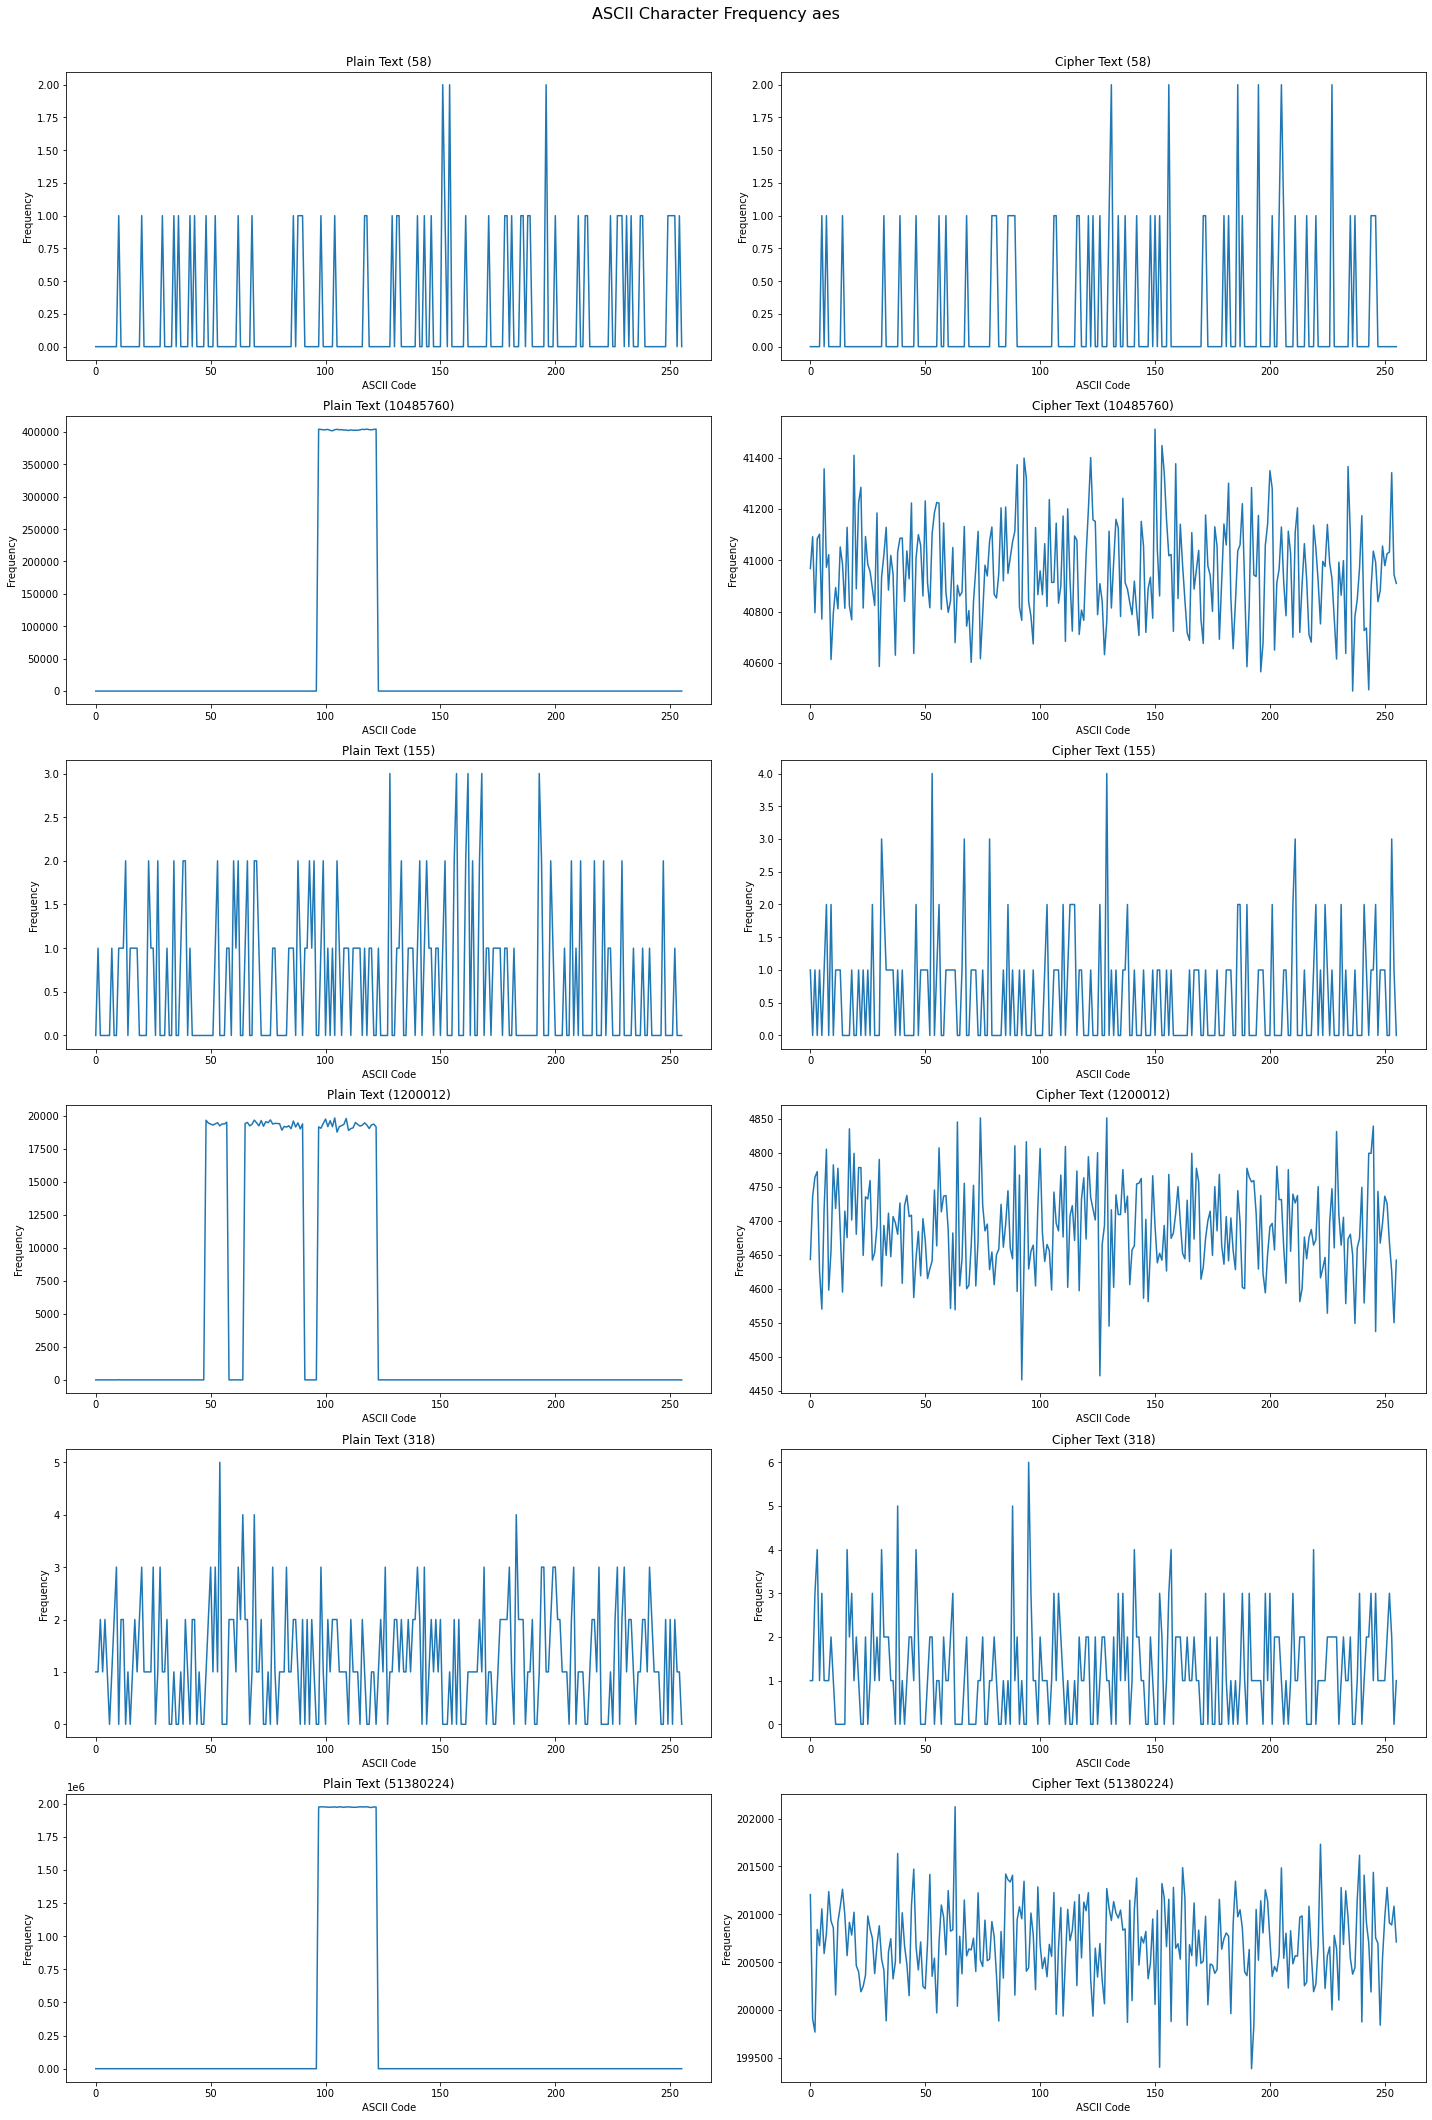

In [12]:
plotAsciiCodeFreqMap(RES_DATA["aes"], "aes")

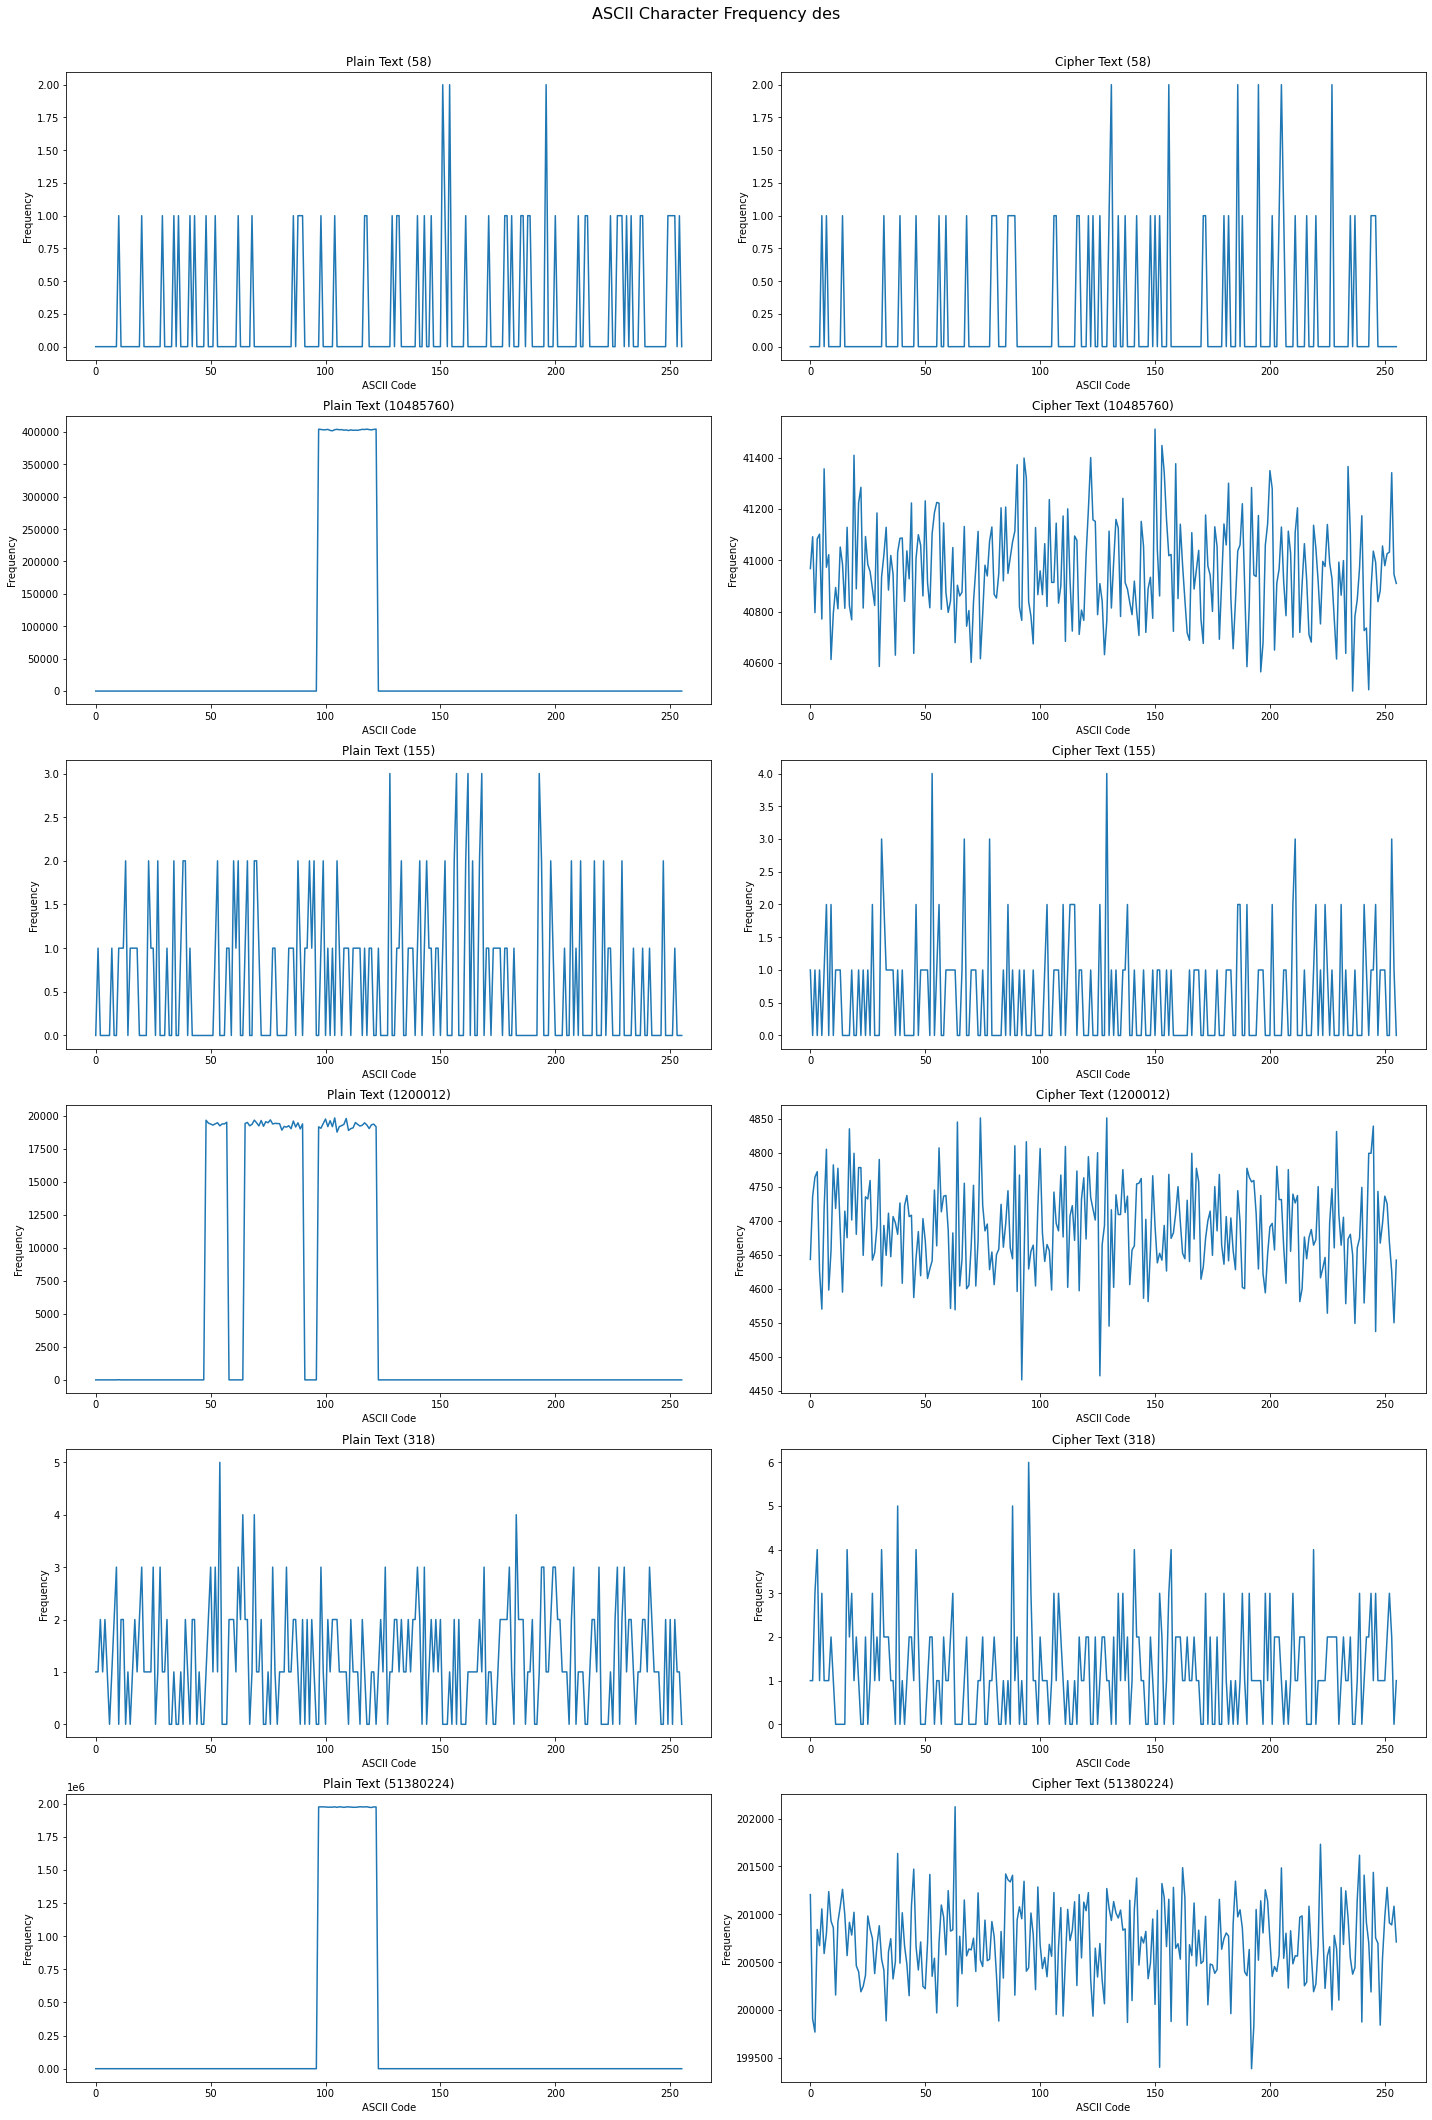

In [13]:
plotAsciiCodeFreqMap(RES_DATA["des"], "des")

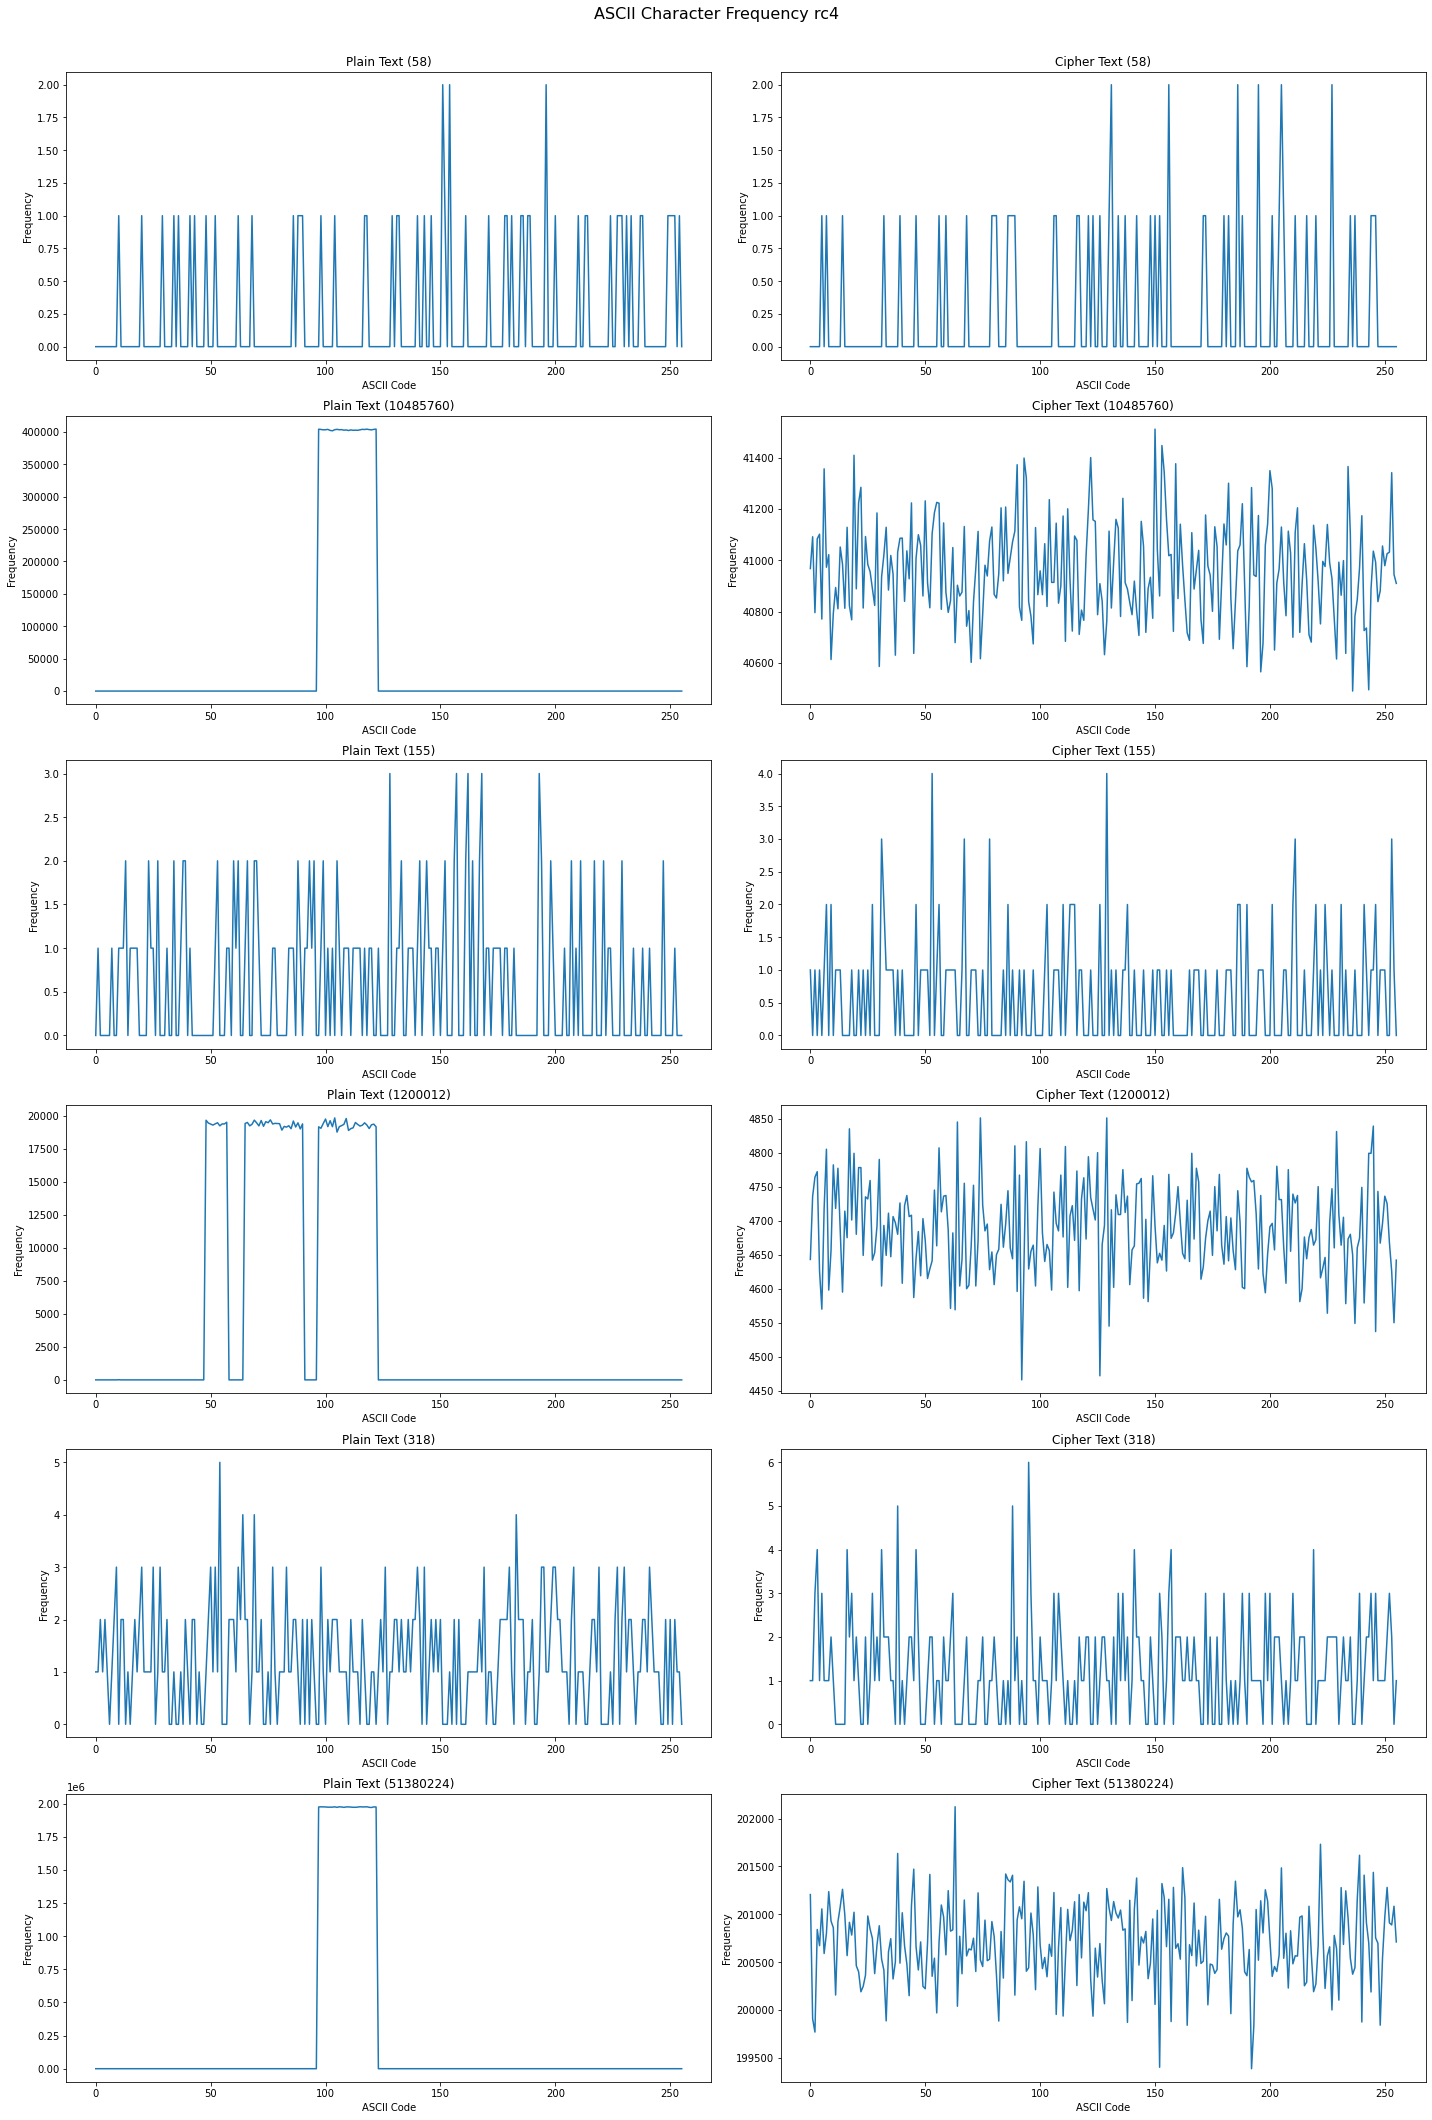

In [14]:
plotAsciiCodeFreqMap(RES_DATA["rc4"], "rc4")

# Print Count of Zeros and Ones

In [15]:
def countZerosAndOnes(str):
    oneCount = 0
    for c in str:
        if c == "1":
            oneCount += 1
    return abs(len(str) - oneCount), oneCount

def countZeroesAndOnesInPlainTextAndCipherText(data):
    plainTextLengths = [PT_DATA[d.plainTextId].length for d in data]
    cipherTextLengths = [d.cipherText.length for d in data]
    
    ptOneCounts = []
    ptZeroCounts = []
    ctOneCounts = []
    ctZeroCounts = []
    
    for i in range(0, len(data)):
        ptZeroCount, ptOneCount = countZerosAndOnes(PT_DATA[data[i].plainTextId].bins)
        ptZeroCounts.append(ptZeroCount)
        ptOneCounts.append(ptOneCount)
        
        ctZeroCount, ctOneCount = countZerosAndOnes(data[i].cipherText.bins)
        ctZeroCounts.append(ctZeroCount)
        ctOneCounts.append(ctOneCount)
    
    return pd.DataFrame(data={
        "plain text length": plainTextLengths,
        "cipher text length": cipherTextLengths,
        
        "plain text total bits": [len(PT_DATA[d.plainTextId].bins) for d in data],
        "cipher text total bits": [len(d.cipherText.bins) for d in data],
        
        "plain text 0s": ptZeroCounts,
        "plain text 1s": ptOneCounts,
        
        "cipher text 0s": ctZeroCounts,
        "cipher text 1s": ctOneCounts,
    })

In [16]:
countZeroesAndOnesInPlainTextAndCipherText(RES_DATA["aes"])

,plain text length,cipher text length,plain text total bits,cipher text total bits,plain text 0s,plain text 1s,cipher text 0s,cipher text 1s
0,58,58,464,464,225,239,223,241
1,10485760,10485760,83886080,83886080,38717003,45169077,41946422,41939658
2,155,155,1240,1240,645,595,609,631
3,1200012,1200012,9600096,9600096,5094728,4505368,4802298,4797798
4,318,318,2544,2544,1305,1239,1279,1265
5,51380224,51380224,411041792,411041792,189711491,221330301,205503736,205538056


In [17]:
countZeroesAndOnesInPlainTextAndCipherText(RES_DATA["des"])

,plain text length,cipher text length,plain text total bits,cipher text total bits,plain text 0s,plain text 1s,cipher text 0s,cipher text 1s
0,58,58,464,464,225,239,223,241
1,10485760,10485760,83886080,83886080,38717003,45169077,41946422,41939658
2,155,155,1240,1240,645,595,609,631
3,1200012,1200012,9600096,9600096,5094728,4505368,4802298,4797798
4,318,318,2544,2544,1305,1239,1279,1265
5,51380224,51380224,411041792,411041792,189711491,221330301,205503736,205538056


In [18]:
countZeroesAndOnesInPlainTextAndCipherText(RES_DATA["rc4"])

,plain text length,cipher text length,plain text total bits,cipher text total bits,plain text 0s,plain text 1s,cipher text 0s,cipher text 1s
0,58,58,464,464,225,239,223,241
1,10485760,10485760,83886080,83886080,38717003,45169077,41946422,41939658
2,155,155,1240,1240,645,595,609,631
3,1200012,1200012,9600096,9600096,5094728,4505368,4802298,4797798
4,318,318,2544,2544,1305,1239,1279,1265
5,51380224,51380224,411041792,411041792,189711491,221330301,205503736,205538056


# Plot Running Times Mean

In [53]:
def plotEncryptDecryptRunningTimesMean():
    
    # sort by plain text lengths
    tmp = [(PT_DATA[i].length, i) for i in range(0, len(PT_DATA))]
    tmp.sort()
    
    # original indices after sorting
    sortedIdx = [i[1] for i in tmp]
    # sorted plain text lengths
    sortedPtLens = [i[0] for i in tmp]
    
    sortedAes = []
    sortedDes = []
    sortedRc4 = []
    
    for i in sortedIdx:
        sortedAes.append(RES_DATA["aes"][i])
        sortedDes.append(RES_DATA["des"][i])
        sortedRc4.append(RES_DATA["rc4"][i])

    # left col: encrypt and right col: decrypt
    colCount = 2
    rowCount = 1
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 7))
    
    fig.suptitle(f"Running Time Mean", fontsize=16)

    ax[0].plot(sortedPtLens, np.array([i.encRtMean for i in sortedAes]), color='r', label="aes")
    ax[0].plot(sortedPtLens, np.array([i.encRtMean for i in sortedDes]), color='g', label="des")
    ax[0].plot(sortedPtLens, np.array([i.encRtMean for i in sortedRc4]), color='b', label="rc4")
    
    ax[0].set_title(f"Encrypt")
    ax[0].set_xlabel('Plain Text Length')
    ax[0].set_ylabel('Running Time Mean (ms)')
    ax[0].legend(loc="upper left")
    
    ax[1].plot(sortedPtLens, np.array([i.decRtMean for i in sortedAes]), color='r', label="aes")
    ax[1].plot(sortedPtLens, np.array([i.decRtMean for i in sortedDes]), color='g', label="des")
    ax[1].plot(sortedPtLens, np.array([i.decRtMean for i in sortedRc4]), color='b', label="rc4")
    
    ax[1].set_title(f"Decrypt")
    ax[1].set_xlabel('Plain Text Length')
    ax[1].set_ylabel('Running Time Mean (ms)')
    ax[1].legend(loc="upper left")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

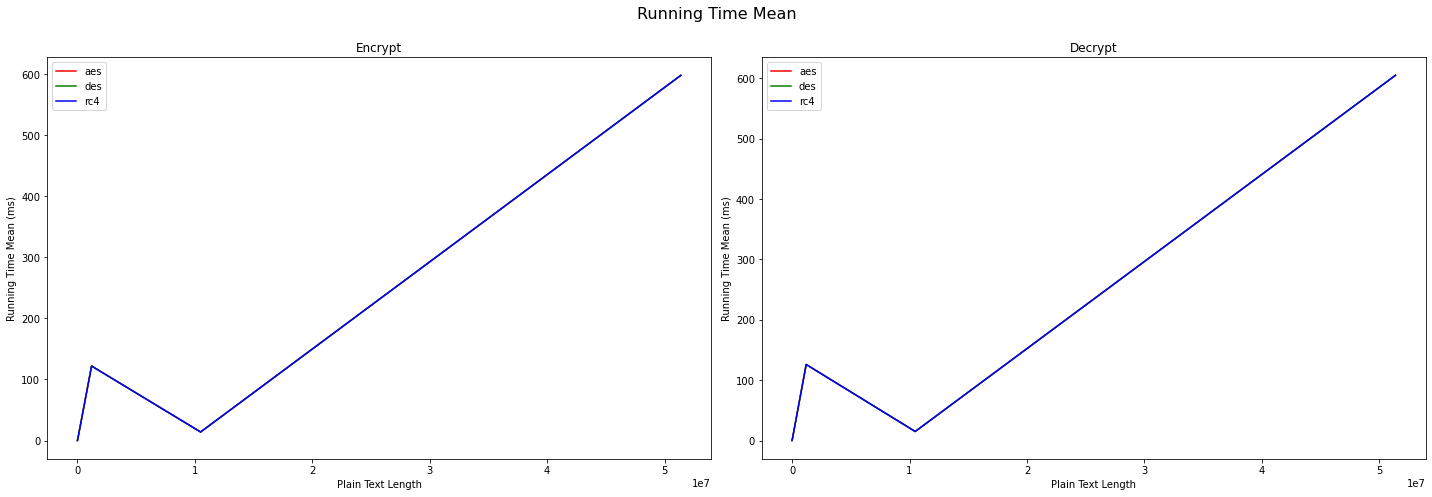

In [54]:
plotEncryptDecryptRunningTimesMean()

# Plot Running Times Population Standard Deviation

In [55]:
def plotEncryptDecryptRunningTimesPopStdDev():
    plainTextLengths = [i.length for i in PT_DATA]
    
    # sort by plain text lengths
    tmp = [(PT_DATA[i].length, i) for i in range(0, len(PT_DATA))]
    tmp.sort()
    
    # original indices after sorting
    sortedIdx = [i[1] for i in tmp]
    # sorted plain text lengths
    sortedPtLens = [i[0] for i in tmp]
    
    sortedAes = []
    sortedDes = []
    sortedRc4 = []
    
    for i in sortedIdx:
        sortedAes.append(RES_DATA["aes"][i])
        sortedDes.append(RES_DATA["des"][i])
        sortedRc4.append(RES_DATA["rc4"][i])
    
    # left col: encrypt and right col: decrypt
    colCount = 2
    rowCount = 1
    
    fig, ax = plt.subplots(rowCount, colCount, figsize=(20, 7))
    
    fig.suptitle(f"Running Time Population Standard Deviation", fontsize=16)

    ax[0].plot(sortedPtLens, np.array([i.encRtPopStdDev for i in sortedAes]), color='r', label="aes")
    ax[0].plot(sortedPtLens, np.array([i.encRtPopStdDev for i in sortedDes]), color='g', label="des")
    ax[0].plot(sortedPtLens, np.array([i.encRtPopStdDev for i in sortedRc4]), color='b', label="rc4")
    
    ax[0].set_title(f"Encrypt")
    ax[0].set_xlabel('Plain Text Length')
    ax[0].set_ylabel('Running Time Population Standard Deviation')
    ax[0].legend(loc="upper left")
    
    ax[1].plot(sortedPtLens, np.array([i.decRtPopStdDev for i in sortedAes]), color='r', label="aes")
    ax[1].plot(sortedPtLens, np.array([i.decRtPopStdDev for i in sortedDes]), color='g', label="des")
    ax[1].plot(sortedPtLens, np.array([i.decRtPopStdDev for i in sortedRc4]), color='b', label="rc4")
    
    ax[1].set_title(f"Decrypt")
    ax[1].set_xlabel('Plain Text Length')
    ax[1].set_ylabel('Running Time Population Standard Deviation')
    ax[1].legend(loc="upper left")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

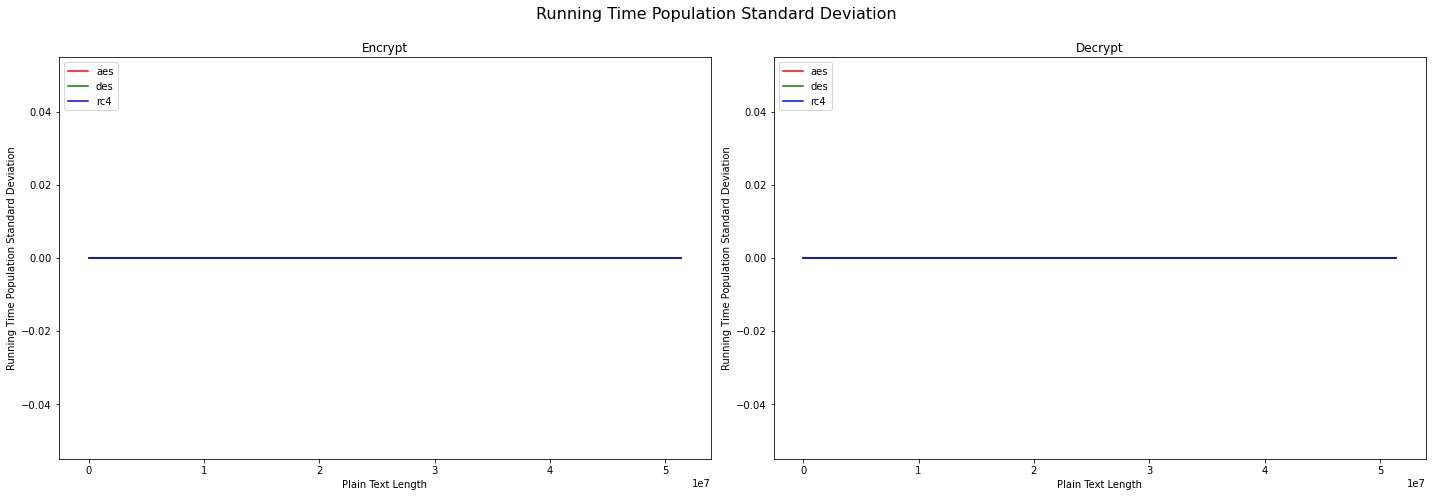

In [56]:
plotEncryptDecryptRunningTimesPopStdDev()

# Measure Plain Text and Cipher Text Similarities

In [23]:
# def getSequenceMatcherRatio(a, b):
#     return SequenceMatcher(None, a, b).ratio()

# def getCosine(vec1, vec2):
#     intersection = set(vec1.keys()) & set(vec2.keys())
#     numerator = sum([vec1[x] * vec2[x] for x in intersection])

#     sum1 = sum([vec1[x]**2 for x in vec1.keys()])
#     sum2 = sum([vec2[x]**2 for x in vec2.keys()])
#     denominator = math.sqrt(sum1) * math.sqrt(sum2)

#     if not denominator:
#         return 0.0
#     else:
#         return float(numerator) / denominator


# def textToVector(text):
#     word = re.compile(r'\w+')
#     words = word.findall(text)
#     return Counter(words)


# def getCosineSimilarity(a, b):
#     return getCosine(
#         textToVector(a),
#         textToVector(b)
#     )

In [24]:
# def measurePlainTextAndCipherTextSimilarities(data):
#     plainTextLengths = [PT_DATA[d.plainTextId].length for d in data]
#     cipherTextLengths = [d.cipherText.length for d in data]
    
#     return pd.DataFrame(data={
#         "plain text length": plainTextLengths,
#         "cipher text length": cipherTextLengths,
#         "sequence matcher": [getSequenceMatcherRatio(PT_DATA[d.plainTextId].str, d.cipherText.str) for d in data],
#         "cosine similarity": [getCosineSimilarity(PT_DATA[d.plainTextId].str, d.cipherText.str) for d in data]
#     })

In [25]:
# pd.set_option('display.max_rows', None)

In [26]:
# measurePlainTextAndCipherTextSimilarities(RES_DATA["aes"])

In [27]:
# measurePlainTextAndCipherTextSimilarities(RES_DATA["des"])

In [28]:
# measurePlainTextAndCipherTextSimilarities(RES_DATA["rc4"])